# Predicting faulty water pumps

## Optimize Model Paramaters¶

## Import Libraries
Import libraries necessary to get the models trained

In [1]:
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from IPython.display import display  # use of display() for DataFrames

# Import Preprocessing and ML libraries
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, f1_score

from xgboost import XGBClassifier


%matplotlib inline

In [2]:
# Utility encoder function
def encode_label(label_series):
    encoder = LabelEncoder()
    encoder.fit(label_series)
    encoded_label_series = encoder.transform(label_series)
    return (utils.to_categorical(encoded_label_series))

## Select environment

In [3]:
# Choose Environment: 'floydhub' or 'local'
model_env = 'local' 

In [4]:
if model_env == 'local':
    import keras
    import mxnet as mx
#    import tensorflow as tf
    from keras import utils
    from keras.callbacks import ModelCheckpoint
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras.wrappers.scikit_learn import KerasClassifier    

    # Show the deep learning library versions
    print ("MXNet version = {}".format(mx.__version__))
    print ("Keras version = {}".format(keras.__version__))

Using MXNet backend


MXNet version = 1.2.0
Keras version = 2.2.0


In [40]:
# import tensorflow as tf
#if tf.test.gpu_device_name():
#    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
#else:
#    print("Please install GPU version of TF")

In [5]:
if model_env == 'local':
    # check GPU status
    def gpu_device(gpu_number=0):
        try:
            _ = mx.nd.array([1, 2, 3], ctx=mx.gpu(gpu_number))
        except mx.MXNetError:
            return None
        return mx.gpu(gpu_number)

    gpu = gpu_device()
    if not gpu:
        print('No GPU device found!')
    else:
        print("GPU found! => {}".format(gpu))

GPU found! => gpu(0)


### Directory path and file where model will be saved 

In [6]:
model_data_dir = 'model-tuning\\'
# model_nn_file = model_data_dir + 'pump_train_nn_weights_best.hdf5'
# model_nn_file = 'pump_train_nn_weights_best.hdf5'

## Load Water Pump Data Files, Create Data Frames and Clean The Data

### Read in the data pump files stored in the directory raw-data into Pandas dataframes

In [6]:
if model_env == 'local':
    !dir clean-data\*.pkl
else:
    !ls /clean-data/*.pkl

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\clean-data

07/28/2018  04:20 PM        15,825,599 clean_wp_data_object.pkl
07/28/2018  03:05 PM        15,823,293 clean_wp_data_object_18072815.pkl
07/28/2018  02:23 PM         3,048,453 clean_wp_test_features_df_18072814.pkl
07/28/2018  03:05 PM         3,048,453 clean_wp_test_features_df_18072815.pkl
07/28/2018  02:23 PM        12,241,432 clean_wp_train_features_df_18072814.pkl
07/28/2018  03:05 PM        12,241,432 clean_wp_train_features_df_18072815.pkl
               6 File(s)     62,228,662 bytes
               0 Dir(s)  1,927,182,659,584 bytes free


### Load Cleaned Water Pump Data Set

In [8]:
local_file_path = 'clean-data\\clean_wp_train_features_df_18072814.pkl'
floydhub_file_path = '/clean-data/clean_wp_train_features_df_18071011.pkl'

if model_env == 'local':
    wp_test_file = local_file_path
else:
    wp_test_file = floydhub_file_path

print("Environment is {} => {}".format(
    model_env, wp_test_file))

test_df = pd.read_pickle(wp_test_file)
test_df.shape

Environment is local => clean-data\clean_wp_train_features_df_18072814.pkl


(59400, 122)

### Create a training and test sets to evaluate models 

In [9]:
label_col = 'status_group'
target_df = test_df[label_col]
feature_df = test_df.drop(label_col, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    feature_df, target_df, test_size=0.3)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape))
print("Testing set has {} samples.".format(X_test.shape))

Training set has (41580, 121) samples.
Testing set has (17820, 121) samples.


In [10]:
y_test.head()

6049         functional
13141    non functional
35647        functional
56359    non functional
11804        functional
Name: status_group, dtype: category
Categories (3, object): [functional, functional needs repair, non functional]

### Tune two ensemble models on the data set

#### Tune the Random Forest Model
Use a gridsearch with key model hyper parameters

In [16]:
rfc = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

# n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
# max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
# bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

parameters = {'n_estimators': [500, 1000, 2000], 'max_depth': [5, 20, 30, 40, 50],
              'min_samples_leaf': [1, 4, 8],'min_samples_split': [2, 5, 10]}

# to better manage imbalance outcome classes
sss_cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)

# Make an f1_score scoring object using make_scorer()
scorer = make_scorer(f1_score, average='macro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = RandomizedSearchCV(estimator=rfc, param_distributions=parameters,
                        scoring=scorer, cv=sss_cv, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

In [17]:
model_name = rfc.__class__.__name__
print("Best estimator for model {} => {}".format(model_name, grid_fit.best_estimator_))
print("Best parameters for model {} => {}".format(model_name, grid_fit.best_params_))
print("Best score {} => {}".format(model_name, grid_fit.best_score_))

Best estimator for model RandomForestClassifier => RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best parameters for model RandomForestClassifier => {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 50}
Best score RandomForestClassifier => 0.684996161391587


In [18]:
important_feature_list = pd.Series(grid_fit.best_estimator_.feature_importances_,list(X_train)).sort_values(ascending=False).head(20)
print("Feature importance for model {}\n{}".format(model_name, important_feature_list))

Feature importance for model RandomForestClassifier
longitude                             0.104471
latitude                              0.096674
quantity_dry                          0.067558
id                                    0.062325
gps_height                            0.050139
pump_age                              0.041752
construction_year                     0.037729
population                            0.036491
district_code                         0.033389
quantity_enough                       0.022296
extraction_type_other                 0.022215
region_code                           0.022165
amount_tsh                            0.021525
waterpoint_type_other                 0.021422
extraction_type_gravity               0.018072
quantity_insufficient                 0.015036
payment_never pay                     0.011439
waterpoint_type_communal standpipe    0.011051
permit                                0.010760
waterpoint_type_hand pump             0.009384
dtype: f

#### Tune the Gradient Boosting Model
Use a gridsearch with key model hyper parameters

In [ ]:
gbm = GradientBoostingClassifier(n_estimators=1000, subsample=0.5)

# loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’,
# min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
# min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None,
# warm_start=False, presort=’auto’

parameters = {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}

# to better manage imbalance outcome classes
sss_cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)

# Make an f1_score scoring object using make_scorer()
scorer = make_scorer(f1_score, average='macro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=gbm, param_grid=parameters, scoring=scorer, cv=sss_cv, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

In [ ]:
model_name = gbm.__class__.__name__
print("Best estimator for model {} => {}".format(
    model_name, grid_fit.best_estimator_))
print("Best parameters for model{} => {}".format(
    model_name, grid_fit.best_params_))
print("Best score {} => {}".format(model_name, grid_fit.best_score_))

Best estimator for model GradientBoostingClassifier => GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
Best parameters for modelGradientBoostingClassifier => {'learning_rate': 0.1, 'max_depth': 5}
Best score GradientBoostingClassifier => 0.6597379773736959


In [19]:

def select_gbm_params(max_estimators=1000, max_depth = 5, learning_rate=0.01):
    #f1_scorer = make_scorer(f1_score, average='macro')
    gbm = GradientBoostingClassifier(n_estimators = max_estimators, learning_rate=learning_rate, 
                                    max_depth=max_depth, subsample=0.5)
    gbm.fit(X_train, y_train)
    test_score = np.zeros((max_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_predict(X_test)):
        test_score[i] = f1_score(y_test, y_pred, average='macro')
        
    print('optimal number of trees: {0}'.format(test_score.argmin()))
    print('best f1 score: {0}'.format(test_score.max()))
    pd.Series(test_score).plot(title='learning curve for max_depth = {0}'.format(max_depth))
    plt.show()

***** training for max depth = 5 *****


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


optimal number of trees: 0
best f1 score: 0.6677448376064502


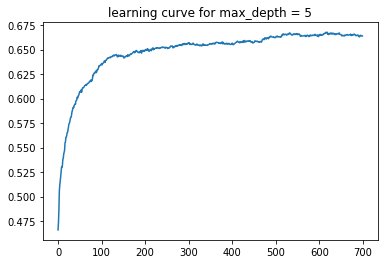

***** training for max depth = 8 *****
optimal number of trees: 0
best f1 score: 0.6743601947034129


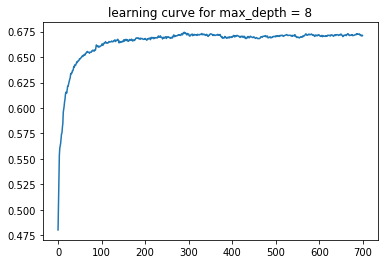

***** training for max depth = 12 *****
optimal number of trees: 0
best f1 score: 0.6772134682676331


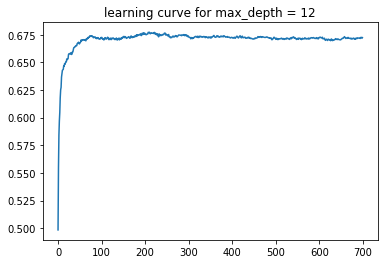

***** training for max depth = 15 *****
optimal number of trees: 0
best f1 score: 0.6782295634581995


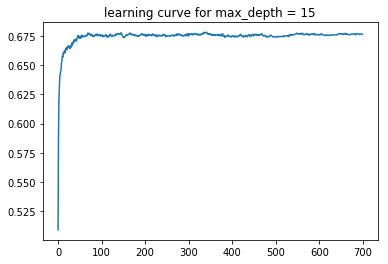

In [20]:
for depth in [5, 8, 12, 15]:
    print('***** training for max depth = {0} *****'.format(depth))
    select_gbm_params(max_estimators=700, max_depth=depth, learning_rate=0.12)

#### Evaluate the XG Boosting Model

In [24]:
xgbc = XGBClassifier(
 eta = 0.2,
 booster = "gbtree",
 n_estimators=500,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 num_class = 3,
 objective= 'multi:softmax',
 n_jobs=-1,
 scale_pos_weight=1)

custom_scorer = make_scorer(f1_score, average='macro')

xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
test_score = f1_score(y_test, y_pred, average='macro')

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [25]:
test_score

0.6746395670220732

In [29]:
xgbc = XGBClassifier()
learning_rate = [0.01, 0.1, 0.3]
n_estimators = [500, 700, 1000]
max_depth = [8, 12, 15, 18]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)

custom_scorer = make_scorer(f1_score, average='macro')

kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(xgbc, param_grid, scoring=custom_scorer, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

In [30]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.669573 using {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 500}
0.625123 (0.006198) with: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500}
0.631423 (0.005453) with: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 700}
0.638256 (0.004521) with: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000}
0.655198 (0.006881) with: {'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 500}
0.657737 (0.006587) with: {'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 700}
0.660946 (0.007957) with: {'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 1000}
0.662965 (0.006731) with: {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 500}
0.665020 (0.007206) with: {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 700}
0.665573 (0.007320) with: {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000}
0.665774 (0.005590) with: {'learning_rate': 0.01, 'max_depth': 18, 'n_estimators': 500}
0.665950 (0.005419) with: {'learning_r

#### Create and Evaluate the Neural Network Model
Use cross validation to tune the model's hyper parameters

In [41]:
from keras import metrics
from keras.callbacks import ModelCheckpoint
# Function to create a NN model for KerasClassifier

def create_nn_model(input_shape, output_shape):
    print("create_model() with input dim = {} and output dim = {}".format(
        input_shape, output_shape))
    # create NN model - 3 layers
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))
    model.add(Dense(32, input_dim=input_shape, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    # Compile model, use GPU
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'], context=['gpu(0)'])

    print(model.summary())
    return model

In [42]:
#y_train = encode_label(y_train)

In [43]:
y_train.unique()

[functional, non functional, functional needs repair]
Categories (3, object): [functional, non functional, functional needs repair]

In [44]:
y_train.nunique()

3

In [45]:
input_dim = X_train.shape[1]
output_dim = y_train.nunique()
n_epoch = 70
batch_sz = 16
verbose = 1

# Build two layer neural network
nn_model = KerasClassifier(build_fn=create_nn_model, input_shape=input_dim,
                           output_shape=output_dim,  epochs=n_epoch, batch_size=batch_sz, verbose=verbose)

#nn_model2 = create_nn_model(input_shape=input_dim, output_shape=output_dim)
nn_model_pipeline = make_pipeline(StandardScaler(), nn_model)

# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=2, shuffle=True)
results = cross_val_score(nn_model_pipeline, X_train, y_train, cv=kfold)

create_model() with input dim = 121 and output dim = 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                7808      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 27        
Total params: 10,179
Trainable params: 10,179
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
  144/20789 [..............................] - ETA: 40s - loss: 1.0142 - acc: 0.5556 

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mxnet\module\bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0625). Is this intended?
  force_init=force_init)


20789/20789 [==============================] - 11s 540us/step - loss: 0.6731 - acc: 0.7192
Epoch 2/70
20789/20789 [==============================] - 11s 509us/step - loss: 0.6007 - acc: 0.7502
Epoch 3/70
20789/20789 [==============================] - 10s 472us/step - loss: 0.5774 - acc: 0.7612
Epoch 4/70
20789/20789 [==============================] - 9s 455us/step - loss: 0.5589 - acc: 0.7693
Epoch 5/70
20789/20789 [==============================] - 10s 475us/step - loss: 0.5467 - acc: 0.7743
Epoch 6/70
20789/20789 [==============================] - 11s 509us/step - loss: 0.5335 - acc: 0.7815
Epoch 7/70
20789/20789 [==============================] - 12s 568us/step - loss: 0.5249 - acc: 0.7857
Epoch 8/70
20789/20789 [==============================] - 10s 469us/step - loss: 0.5153 - acc: 0.7894
Epoch 9/70
20789/20789 [==============================] - 9s 450us/step - loss: 0.5063 - acc: 0.7917
Epoch 10/70
20789/20789 [==============================] - 10s 477us/step - loss: 0.5000 - acc:

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205217). Check your callbacks.
  % delta_t_median)


20789/20789 [==============================] - 10s 485us/step - loss: 0.3756 - acc: 0.8441
Epoch 49/70
20789/20789 [==============================] - 10s 466us/step - loss: 0.3743 - acc: 0.8464
Epoch 50/70
20789/20789 [==============================] - 10s 488us/step - loss: 0.3724 - acc: 0.8452
Epoch 51/70
20789/20789 [==============================] - 10s 474us/step - loss: 0.3730 - acc: 0.8441
Epoch 52/70
20789/20789 [==============================] - 10s 467us/step - loss: 0.3682 - acc: 0.8489
Epoch 53/70
20789/20789 [==============================] - 9s 445us/step - loss: 0.3687 - acc: 0.8476
Epoch 54/70
20789/20789 [==============================] - 10s 472us/step - loss: 0.3675 - acc: 0.8475
Epoch 55/70
20789/20789 [==============================] - 10s 492us/step - loss: 0.3642 - acc: 0.8488
Epoch 56/70
20789/20789 [==============================] - 9s 440us/step - loss: 0.3654 - acc: 0.8472
Epoch 57/70
20789/20789 [==============================] - 9s 455us/step - loss: 0.3629

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mxnet\module\bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0625). Is this intended?
  force_init=force_init)


20791/20791 [==============================] - 12s 572us/step - loss: 0.6621 - acc: 0.7232
Epoch 2/70
20791/20791 [==============================] - 12s 588us/step - loss: 0.5888 - acc: 0.7570
Epoch 3/70
20791/20791 [==============================] - 12s 577us/step - loss: 0.5637 - acc: 0.7667
Epoch 4/70
20791/20791 [==============================] - 12s 585us/step - loss: 0.5457 - acc: 0.7743
Epoch 5/70
20791/20791 [==============================] - 11s 506us/step - loss: 0.5331 - acc: 0.7794
Epoch 6/70
20791/20791 [==============================] - 11s 550us/step - loss: 0.5215 - acc: 0.7854
Epoch 7/70
20791/20791 [==============================] - 10s 482us/step - loss: 0.5123 - acc: 0.7906
Epoch 8/70
20791/20791 [==============================] - 10s 493us/step - loss: 0.5030 - acc: 0.7945
Epoch 9/70
20791/20791 [==============================] - 11s 505us/step - loss: 0.4969 - acc: 0.7955
Epoch 10/70
20791/20791 [==============================] - 10s 480us/step - loss: 0.4880 - ac